# Excel + Python 베이즈 최적화 튜토리얼

## 목적
* Excel의 기존 수식/VBA 자산을 그대로 활용
* Python에서 베이즈 최적화를 통해 Excel 모델의 최적 파라미터 탐색
* xlwings를 사용해서 Excel 계산 엔진을 직접 활용
* 블랙박스 최적화의 실용적 예제 제시

## 시나리오
* Excel에 복잡한 수식이 들어있는 모델 
* 입력 파라미터 (x, y)를 조정해서 목적 함수 값을 최소화/최대화
* 사람이 수동으로 조정하는 대신 베이즈 최적화로 자동 탐색

## 라이브러리 import

In [1]:
!pip install xlwings --quiet
!pip install matplotlib --quiet
!pip install numpy --quiet
!pip install scikit-optimize --quiet
!pip install tqdm --quiet

In [2]:
import os
import xlwings as xw
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

# 베이즈 최적화 라이브러리
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# GIF 애니메이션을 위한 라이브러리
import matplotlib.animation as animation
from matplotlib.colors import Normalize
import IPython.display as ipd

## 로거 설정

In [3]:
# 간단한 로거 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.info('Excel + 베이즈 최적화 튜토리얼 시작')

2025-09-10 16:49:24,588 - INFO - Excel + 베이즈 최적화 튜토리얼 시작


## 상수 정의

In [4]:
# Excel 파일 경로
FILENAME = './formula.xlsx'
HEADLESS = False  # Excel을 화면에 보이지 않게 실행 if True

logger.info(f'파일명: {FILENAME}')
logger.info(f'헤드리스 모드: {HEADLESS}')

2025-09-10 16:49:24,597 - INFO - 파일명: ./formula.xlsx
2025-09-10 16:49:24,598 - INFO - 헤드리스 모드: False


## Excel 연결 및 초기화

In [5]:
# Excel 앱 실행
if HEADLESS:
    app = xw.App(visible=False, add_book=False)
    app.screen_updating = False
else:
    app = xw.App(visible=True, add_book=False)
    app.screen_updating = True

app.display_alerts = False

# Excel 파일이 존재하지 않으면 새로 생성
if not os.path.exists(FILENAME):
    wb = app.books.add()
    ws = wb.sheets[0]
    
    # 튜토리얼용 Excel 시트 구조 생성
    # 라벨 추가
    ws.range('A2').value = 'x (입력 파라미터 1)'
    ws.range('A3').value = 'y (입력 파라미터 2)'
    ws.range('A5').value = '중간 계산 1'
    ws.range('A6').value = '중간 계산 2'
    ws.range('A8').value = '목적 함수 출력'
    
    # 초기값 설정
    ws.range('B2').value = 0  # x 초기값
    ws.range('B3').value = 0  # y 초기값
    
    # 수식 입력
    ws.range('B5').formula = '=SIN(B2) + (B3^2)/10'  # 중간 계산 1
    ws.range('B6').formula = '=EXP(-0.1*B2^2 - 0.1*B3^2)'  # 중간 계산 2  
    ws.range('B8').formula = '=B5*B6 + COS(B3)'  # 목적 함수
    
    # 파일 저장
    wb.save(FILENAME)
    logger.info(f'새로운 Excel 파일 생성: {FILENAME}')
else:
    # 기존 파일 열기
    wb = app.books.open(FILENAME, update_links=False)
    ws = wb.sheets[0]
    logger.info(f'기존 Excel 파일 열기: {FILENAME}')

logger.info('Excel 연결 완료')

2025-09-10 16:49:26,243 - INFO - 기존 Excel 파일 열기: ./formula.xlsx
2025-09-10 16:49:26,244 - INFO - Excel 연결 완료


## 도우미 함수 정의

In [6]:
def set_parameters(x, y):
    """Excel에 입력 파라미터 설정"""
    ws.range('B2').value = x
    ws.range('B3').value = y
    
def get_objective_value():
    """Excel에서 목적 함수 값 읽기"""
    return ws.range('B8').value

def evaluate_function(x, y):
    """파라미터 (x, y)에 대한 목적 함수 값 계산"""
    set_parameters(x, y)
    return get_objective_value()

logger.info('도우미 함수 정의 완료')

logger.info('도우미 함수 정의 완료')

2025-09-10 16:49:26,250 - INFO - 도우미 함수 정의 완료
2025-09-10 16:49:26,251 - INFO - 도우미 함수 정의 완료


In [7]:
def create_excel_charts():
    """Excel에 차트를 생성하여 결과를 시각화"""
    
    # 1. 함수 값 히스토리를 위한 데이터 영역 설정
    history_start_row = 15
    ws.range(f'A{history_start_row}').value = 'Iteration'
    ws.range(f'B{history_start_row}').value = 'Function Value'
    ws.range(f'C{history_start_row}').value = 'Best So Far'
    ws.range(f'D{history_start_row}').value = 'X Parameter'
    ws.range(f'E{history_start_row}').value = 'Y Parameter'
    
    return history_start_row

def update_excel_history(iteration, func_value, best_so_far, x_param, y_param, start_row):
    """Excel에 최적화 히스토리 업데이트"""
    current_row = start_row + 1 + iteration
    ws.range(f'A{current_row}').value = iteration + 1
    ws.range(f'B{current_row}').value = func_value
    ws.range(f'C{current_row}').value = best_so_far
    ws.range(f'D{current_row}').value = x_param
    ws.range(f'E{current_row}').value = y_param


## Excel 함수 테스트

In [8]:
# 몇 개 샘플 포인트에서 함수 값 확인
test_points = [(0, 0), (1, 1), (-1, 2), (2, -1)]

print("테스트 포인트에서 함수값 확인:")
for x, y in test_points:
    value = evaluate_function(x, y)
    print(f"f({x}, {y}) = {value:.4f}")

테스트 포인트에서 함수값 확인:
f(0, 0) = 1.0000
f(1, 1) = 1.3111
f(-1, 2) = -0.6839
f(2, -1) = 1.1525


### GIF 애니메이션 시각화 기능

이 튜토리얼에서는 베이즈 최적화 탐색 과정을 다음과 같이 시각화합니다:

1. **등고선 배경**
   - 목적 함수의 전체 지형을 등고선으로 표시
   - 색상이 진할수록 낮은 값 (최솟값을 찾는 경우)

2. **탐색 과정 애니메이션**
   - 빨간 별표: 현재 탐색 중인 포인트
   - 노란 원: 현재까지의 최적점
   - 주황색 점들: 최근 탐색 경로 (5개 포인트)
   - 빨간 선: 최근 탐색 궤적

3. **실시간 정보 표시**
   - 현재 반복 횟수
   - 현재 함수값과 최적값
   - 현재 X, Y 파라미터 값

**장점:**
- 베이즈 최적화의 지능적 탐색 과정을 직관적으로 이해
- 등고선 위에서 어떻게 최적점을 향해 수렴하는지 시각적 확인
- 발표나 교육 자료로 활용하기 적합한 동적 시각화

## 2D 함수 표면 시각화

2025-09-10 16:49:26,590 - INFO - 함수 표면 계산 중...
y 축 진행: 100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


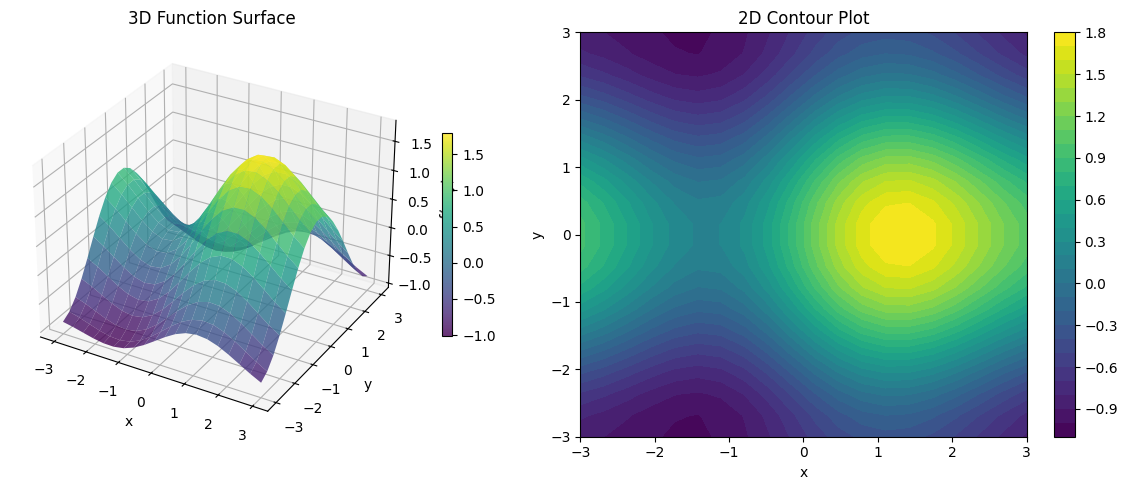

2025-09-10 16:49:31,969 - INFO - 격자 탐색 최적해: f(-1.421, -3.000) = -1.0195


In [9]:
# 함수 표면을 격자 탐색으로 시각화
x_range = np.linspace(-3, 3, 20)
y_range = np.linspace(-3, 3, 20)

X, Y = np.meshgrid(x_range, y_range)
Z = np.zeros_like(X)

logger.info('함수 표면 계산 중...')
for i in tqdm(range(len(y_range)), desc="y 축 진행"):
    for j in range(len(x_range)):
        Z[i, j] = evaluate_function(X[i, j], Y[i, j])

# 3D 표면 플롯
fig = plt.figure(figsize=(12, 5))

# 3D 플롯
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x, y)')
ax1.set_title('3D Function Surface')
fig.colorbar(surf, ax=ax1, shrink=0.5)

# 2D 등고선 플롯
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X, Y, Z, levels=30, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('2D Contour Plot')
fig.colorbar(contour, ax=ax2)

plt.tight_layout()
plt.show()

# 최솟값 위치 찾기 (격자 탐색 기준)
min_idx = np.unravel_index(np.argmin(Z), Z.shape)
grid_optimal_x = X[min_idx]
grid_optimal_y = Y[min_idx]
grid_optimal_value = Z[min_idx]

logger.info(f'격자 탐색 최적해: f({grid_optimal_x:.3f}, {grid_optimal_y:.3f}) = {grid_optimal_value:.4f}')

## 베이즈 최적화 설정

In [10]:
# 탐색 공간 정의
space = [
    Real(-3.0, 3.0, name="x"),
    Real(-3.0, 3.0, name="y"),
]

# 최적화 과정을 추적하기 위한 글로벌 변수 (GIF 생성용)
optimization_history = []

# 목적 함수 정의 (베이즈 최적화용)
@use_named_args(space)
def objective(x, y):
    """베이즈 최적화에서 호출할 목적 함수"""
    global optimization_history
    
    value = evaluate_function(x, y)
    
    # 히스토리에 추가 (GIF 애니메이션용)
    optimization_history.append({
        'iteration': len(optimization_history),
        'x': x,
        'y': y, 
        'value': value
    })
    
    return value  # 최솟값 탐색

logger.info('베이즈 최적화 설정 완료')
logger.info(f'탐색 공간: x ∈ [-3, 3], y ∈ [-3, 3]')

2025-09-10 16:49:31,979 - INFO - 베이즈 최적화 설정 완료
2025-09-10 16:49:31,980 - INFO - 탐색 공간: x ∈ [-3, 3], y ∈ [-3, 3]


## 베이즈 최적화 실행

In [11]:
# 베이즈 최적화 실행
N_CALLS = 50  # 총 함수 평가 횟수
N_INITIAL = 10  # 초기 랜덤 샘플 수

logger.info(f'베이즈 최적화 시작: {N_CALLS}회 평가, 초기 샘플 {N_INITIAL}개')

# 히스토리 초기화
optimization_history = []

res = gp_minimize(
    objective,
    dimensions=space,
    n_calls=N_CALLS,
    n_initial_points=N_INITIAL,
    acq_func="EI",  # Expected Improvement
    random_state=42,
)

# 결과 출력
logger.info('베이즈 최적화 완료')
logger.info(f'최솟값: {res.fun:.6f}')
logger.info(f'최적 파라미터: x = {res.x[0]:.4f}, y = {res.x[1]:.4f}')
logger.info(f'총 평가 횟수: {len(res.x_iters)}회')

print("\n=== 베이즈 최적화 결과 ===")
print(f"최솟값: {res.fun:.6f}")
print(f"최적 파라미터: x = {res.x[0]:.4f}, y = {res.x[1]:.4f}")
print(f"총 평가 횟수: {len(res.x_iters)}회")

# 격자 탐색 결과와 비교
print(f"\n=== 격자 탐색과 비교 ===")
print(f"격자 탐색 최솟값: {grid_optimal_value:.6f}")
print(f"베이즈 최적화 개선: {((grid_optimal_value - res.fun) / abs(grid_optimal_value) * 100):.2f}%")

2025-09-10 16:49:31,988 - INFO - 베이즈 최적화 시작: 50회 평가, 초기 샘플 10개
2025-09-10 16:49:36,684 - INFO - 베이즈 최적화 완료
2025-09-10 16:49:36,685 - INFO - 최솟값: -1.024919
2025-09-10 16:49:36,686 - INFO - 최적 파라미터: x = -1.5240, y = 2.9264
2025-09-10 16:49:36,686 - INFO - 총 평가 횟수: 50회



=== 베이즈 최적화 결과 ===
최솟값: -1.024919
최적 파라미터: x = -1.5240, y = 2.9264
총 평가 횟수: 50회

=== 격자 탐색과 비교 ===
격자 탐색 최솟값: -1.019497
베이즈 최적화 개선: 0.53%


## 최적화 과정 시각화

🔍 최적점 좌표 확인: x = -1.523965, y = 2.926387
🔍 최적 함수값: -1.024919


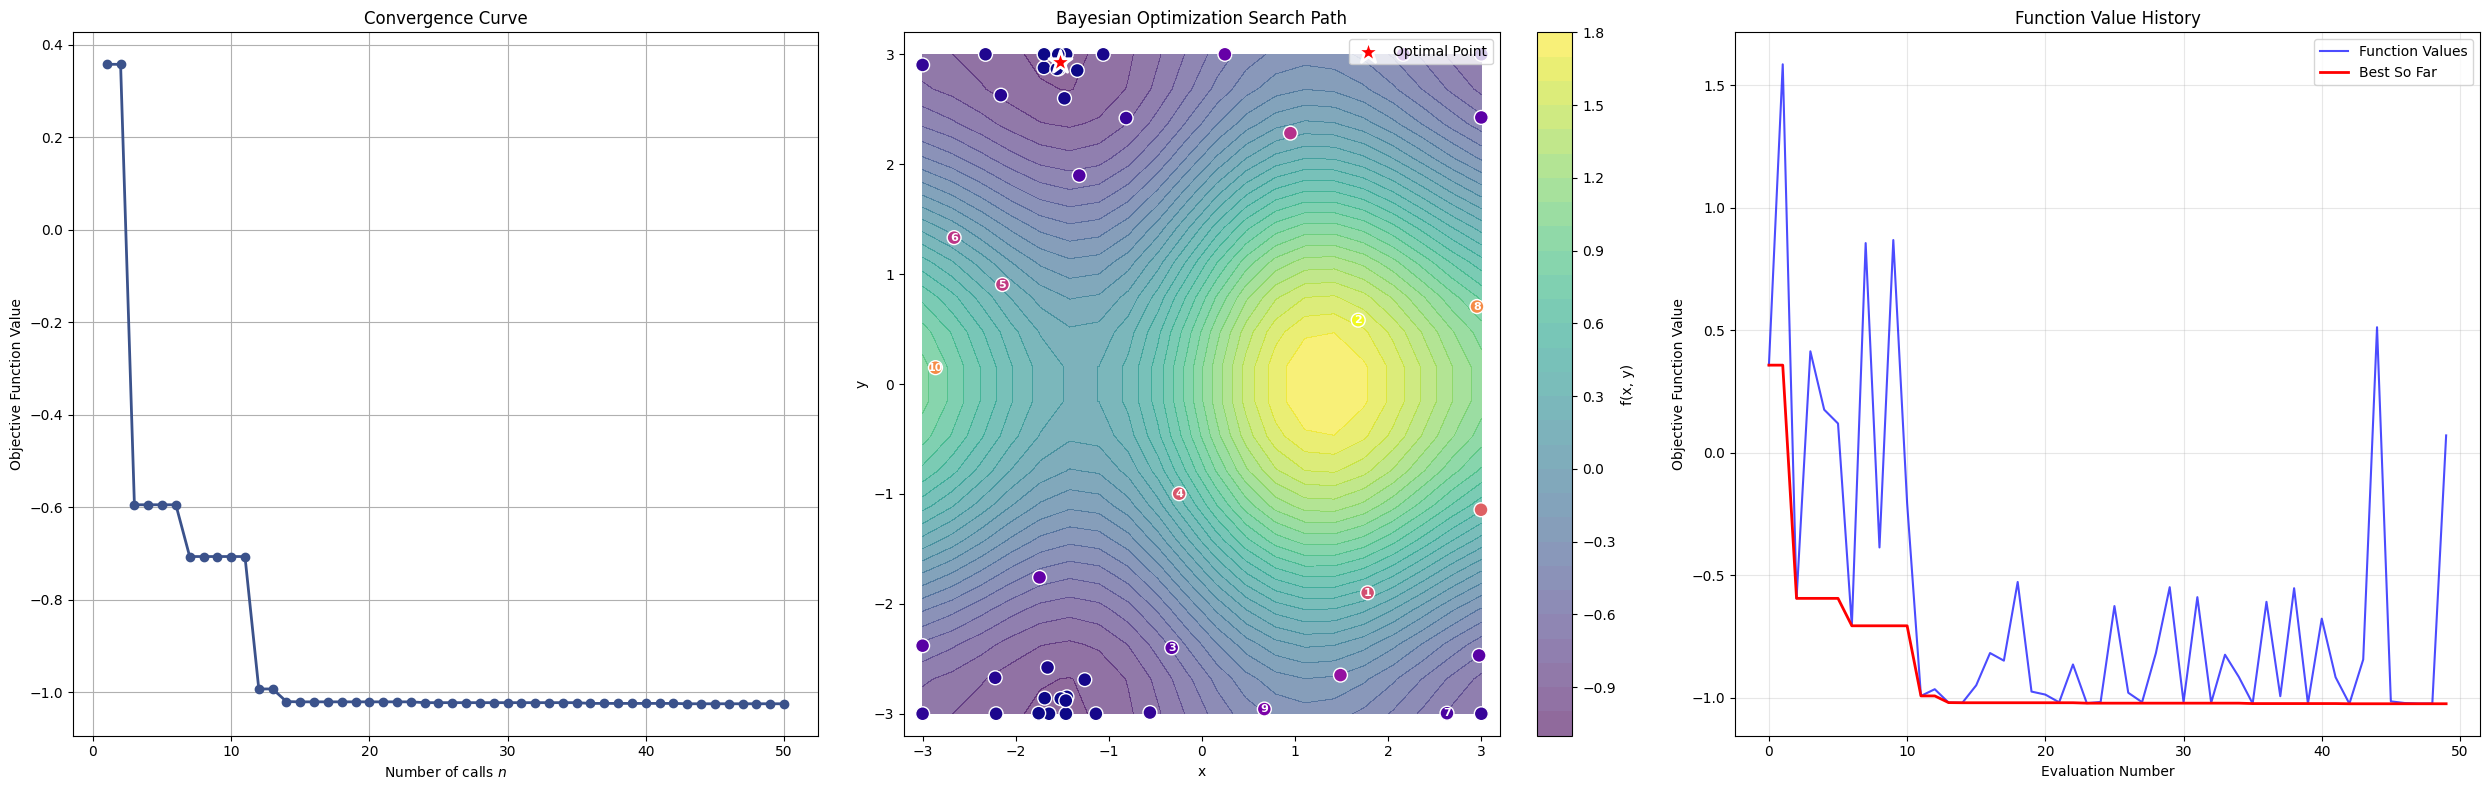

In [12]:
# 수렴 곡선 시각화
plt.figure(figsize=(25, 8))

# 수렴 곡선
plt.subplot(131)
plot_convergence(res)
plt.title('Convergence Curve')
plt.ylabel('Objective Function Value')

# 탐색 경로 시각화
plt.subplot(132)
xs = np.array(res.x_iters)
losses = np.array(res.func_vals)

# 기본 등고선
contour = plt.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.6)
plt.colorbar(contour, label='f(x, y)')

# 탐색 포인트들
scatter = plt.scatter(xs[:, 0], xs[:, 1], c=losses, cmap='plasma', 
                     s=100, edgecolors='white', linewidth=1, zorder=5)

# 탐색 순서 표시 (처음 10개만)
for idx, (x, y) in enumerate(xs[:10]):
    plt.text(x, y, str(idx + 1), fontsize=8, ha='center', va='center',
             color='white', weight='bold', zorder=6)

# 디버깅: 최적점 좌표 확인
print(f"🔍 최적점 좌표 확인: x = {res.x[0]:.6f}, y = {res.x[1]:.6f}")
print(f"🔍 최적 함수값: {res.fun:.6f}")

# 최적점 표시
plt.scatter(res.x[0], res.x[1], marker='*', c='red', s=300, 
           edgecolors='white', linewidth=2, zorder=7, label='Optimal Point')

# 축 범위 명시적 설정 (탐색 공간과 동일하게)
plt.xlim(-3.2, 3.2)
plt.ylim(-3.2, 3.2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Optimization Search Path')
plt.legend(loc='upper right')

# 함수 값 히스토리
plt.subplot(133)
plt.plot(losses, 'b-', alpha=0.7, label='Function Values')
plt.plot(np.minimum.accumulate(losses), 'r-', linewidth=2, label='Best So Far')
plt.xlabel('Evaluation Number')
plt.ylabel('Objective Function Value')
plt.title('Function Value History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 베이즈 최적화 탐색 과정 GIF 애니메이션

2025-09-10 16:49:37,050 - INFO - GIF 애니메이션 생성 중... (총 50 프레임)
2025-09-10 16:49:37,051 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2025-09-10 16:49:43,902 - INFO - GIF 애니메이션 저장 완료: ./bayesian_optimization_search.gif


\n=== GIF 애니메이션 생성 완료 ===
파일명: ./bayesian_optimization_search.gif
프레임 수: 50
GIF를 열어서 베이즈 최적화 탐색 과정을 확인하세요!


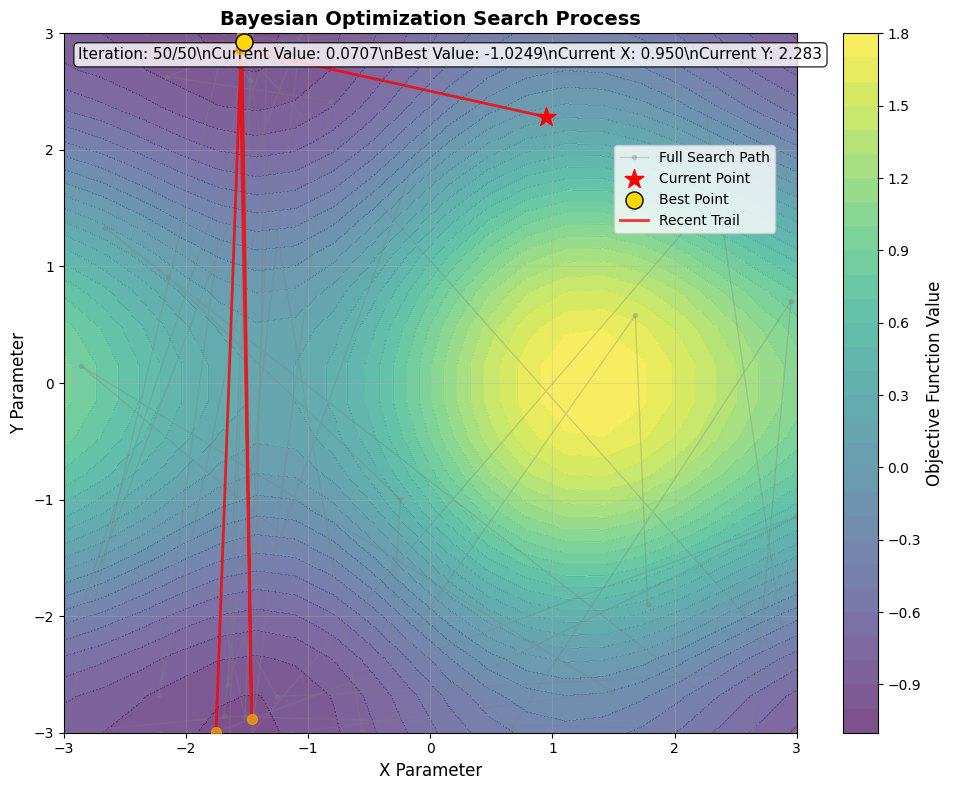

In [13]:
def create_optimization_gif():
    """베이즈 최적화 탐색 과정을 GIF 애니메이션으로 생성"""
    
    if len(optimization_history) == 0:
        logger.warning('최적화 히스토리가 비어있습니다. 베이즈 최적화를 먼저 실행해주세요.')
        return
    
    # 애니메이션 설정
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 등고선 배경 그리기 (한 번만)
    contour = ax.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.7)
    contour_lines = ax.contour(X, Y, Z, levels=30, colors='white', alpha=0.3, linewidths=0.5)
    
    # 컬러바 추가
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Objective Function Value', fontsize=12)
    
    # 축 설정
    ax.set_xlabel('X Parameter', fontsize=12)
    ax.set_ylabel('Y Parameter', fontsize=12)
    ax.set_title('Bayesian Optimization Search Process', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 전체 탐색 경로 (회색으로 미리 그리기)
    all_x = [point['x'] for point in optimization_history]
    all_y = [point['y'] for point in optimization_history]
    ax.plot(all_x, all_y, 'o-', color='gray', alpha=0.3, markersize=3, linewidth=1, label='Full Search Path')
    
    # 애니메이션용 요소들 초기화
    current_point = ax.scatter([], [], s=200, c='red', marker='*', zorder=10, label='Current Point')
    best_point = ax.scatter([], [], s=150, c='gold', marker='o', edgecolors='black', zorder=9, label='Best Point')
    trail_line, = ax.plot([], [], 'r-', linewidth=2, alpha=0.8, label='Recent Trail')
    trail_points = ax.scatter([], [], s=50, c='orange', alpha=0.7, zorder=8)
    
    # 텍스트 정보 추가
    info_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=11,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.85))
    
    def animate(frame):
        if frame >= len(optimization_history):
            return current_point, best_point, trail_line, trail_points, info_text
        
        # 현재까지의 데이터
        current_history = optimization_history[:frame+1]
        current_x = [point['x'] for point in current_history]
        current_y = [point['y'] for point in current_history]
        current_values = [point['value'] for point in current_history]
        
        # 현재 포인트 업데이트
        current_point.set_offsets([[current_x[-1], current_y[-1]]])
        
        # 최적점 찾기 및 업데이트
        best_idx = np.argmin(current_values)
        best_point.set_offsets([[current_x[best_idx], current_y[best_idx]]])
        
        # 최근 5개 포인트의 궤적 표시
        trail_length = min(5, len(current_x))
        trail_x = current_x[-trail_length:]
        trail_y = current_y[-trail_length:]
        trail_line.set_data(trail_x, trail_y)
        
        # 최근 점들 표시 (현재 점 제외)
        if trail_length > 1:
            trail_points.set_offsets(list(zip(trail_x[:-1], trail_y[:-1])))
        
        # 정보 텍스트 업데이트
        info_text.set_text(f'Iteration: {frame + 1}/{len(optimization_history)}\\n'
                          f'Current Value: {current_values[-1]:.4f}\\n'
                          f'Best Value: {min(current_values):.4f}\\n'
                          f'Current X: {current_x[-1]:.3f}\\n'
                          f'Current Y: {current_y[-1]:.3f}')\
        
        return current_point, best_point, trail_line, trail_points, info_text
    
    # 애니메이션 생성
    anim = animation.FuncAnimation(fig, animate, frames=len(optimization_history), 
                                 interval=300, blit=False, repeat=True)
    
    # GIF 저장
    gif_filename = './bayesian_optimization_search.gif'
    logger.info(f'GIF 애니메이션 생성 중... (총 {len(optimization_history)} 프레임)')
    
    try:
        anim.save(gif_filename, writer='pillow', fps=3, dpi=100)
        logger.info(f'GIF 애니메이션 저장 완료: {gif_filename}')
        print(f"\\n=== GIF 애니메이션 생성 완료 ===")
        print(f"파일명: {gif_filename}")
        print(f"프레임 수: {len(optimization_history)}")
        print("GIF를 열어서 베이즈 최적화 탐색 과정을 확인하세요!")
    except Exception as e:
        logger.error(f'GIF 저장 중 오류 발생: {e}')
        print(f"GIF 저장 실패: {e}")
    
    plt.tight_layout()
    plt.show()
    
    return anim

# GIF 애니메이션 생성
optimization_gif = create_optimization_gif()

## 다양한 시작점에서 성능 비교

2025-09-10 16:49:44,037 - INFO - 5회 반복 실행으로 성능 비교...
반복 실행: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


=== 5회 반복 실행 결과 ===
평균 최솟값: -1.023894 ± 0.001203
최고 성능: -1.024979
최악 성능: -1.021593


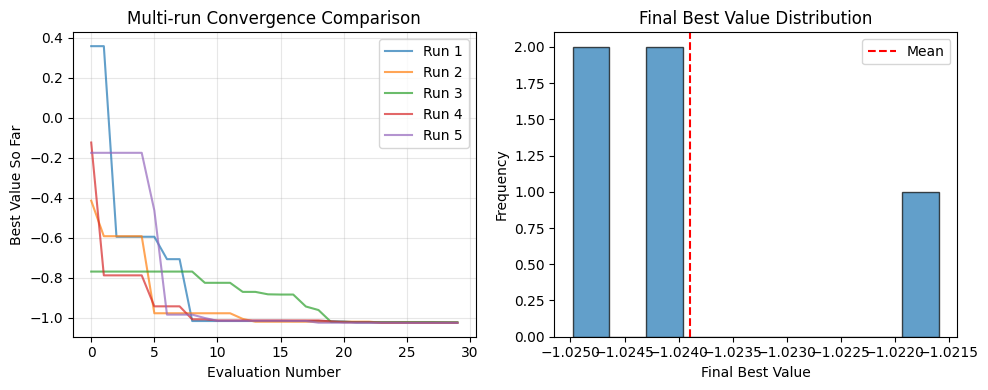

In [14]:
# 여러 번 실행해서 성능 비교
n_runs = 5
n_calls_comparison = 30

results = []
logger.info(f'{n_runs}회 반복 실행으로 성능 비교...')

for run in tqdm(range(n_runs), desc="반복 실행"):
    res_temp = gp_minimize(
        objective,
        dimensions=space,
        n_calls=n_calls_comparison,
        n_initial_points=8,
        acq_func="EI",
        random_state=42 + run,  # 다른 시드
    )
    results.append(res_temp)

# 결과 분석
final_values = [r.fun for r in results]
optimal_points = [r.x for r in results]

print(f"\n=== {n_runs}회 반복 실행 결과 ===")
print(f"평균 최솟값: {np.mean(final_values):.6f} ± {np.std(final_values):.6f}")
print(f"최고 성능: {np.min(final_values):.6f}")
print(f"최악 성능: {np.max(final_values):.6f}")

# 수렴 곡선 비교
plt.figure(figsize=(10, 4))

plt.subplot(121)
for i, r in enumerate(results):
    plt.plot(np.minimum.accumulate(r.func_vals), alpha=0.7, label=f'Run {i+1}')
plt.xlabel('Evaluation Number')
plt.ylabel('Best Value So Far')
plt.title('Multi-run Convergence Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(122)
plt.hist(final_values, bins=10, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(final_values), color='red', linestyle='--', label='Mean')
plt.xlabel('Final Best Value')
plt.ylabel('Frequency')
plt.title('Final Best Value Distribution')
plt.legend()

plt.tight_layout()
plt.show()

## 최적 파라미터로 Excel 업데이트

In [15]:
# 최적 파라미터를 Excel에 적용
best_result = results[np.argmin(final_values)] if len(results) > 1 else res

set_parameters(best_result.x[0], best_result.x[1])

# 최종 결과 확인
final_x = ws.range('B2').value
final_y = ws.range('B3').value
final_intermediate1 = ws.range('B5').value
final_intermediate2 = ws.range('B6').value
final_objective = ws.range('B8').value

print("\n=== Excel 최종 상태 ===")
print(f"입력 파라미터:")
print(f"  x = {final_x:.6f}")
print(f"  y = {final_y:.6f}")
print(f"중간 계산:")
print(f"  중간식 1 = {final_intermediate1:.6f}")
print(f"  중간식 2 = {final_intermediate2:.6f}")
print(f"목적 함수 값: {final_objective:.6f}")


=== Excel 최종 상태 ===
입력 파라미터:
  x = -1.514386
  y = -2.907710
중간 계산:
  중간식 1 = -0.152931
  중간식 2 = 0.341361
목적 함수 값: -1.024979


## 결과 저장 및 정리

In [16]:
# 결과를 새 파일로 저장
result_filename = './formula_optimized.xlsx'

# 최적 파라미터를 위한 요약 정보 추가
ws.range('G2').value = 'Final Optimal Results:'
ws.range('G3').value = f'X = {best_result.x[0]:.6f}'
ws.range('G4').value = f'Y = {best_result.x[1]:.6f}'
ws.range('G5').value = f'Objective = {best_result.fun:.6f}'

# 결과 셀 스타일링 (굵게)
ws.range('G2:G5').font.bold = True

wb.save(result_filename)
logger.info(f'최적화 결과 저장: {result_filename}')

# 최적화 결과를 JSON으로도 저장
import json

optimization_results = {
    'method': 'Bayesian Optimization (scikit-optimize)',
    'best_parameters': {
        'x': float(best_result.x[0]),
        'y': float(best_result.x[1])
    },
    'best_objective_value': float(best_result.fun),
    'total_evaluations': len(best_result.x_iters),
    'optimization_settings': {
        'n_calls': N_CALLS,
        'n_initial_points': N_INITIAL,
        'acquisition_function': 'EI'
    },
    'visualization': {
        'gif_animation': 'bayesian_optimization_search.gif',
        'description': 'GIF shows the search path on contour plot'
    }
}

with open('./optimization_results.json', 'w') as f:
    json.dump(optimization_results, f, indent=2)

logger.info('최적화 결과를 JSON 파일로 저장 완료')
print("\n=== 튜토리얼 완료 ===")
print(f"Excel 파일: {result_filename}")
print(f"결과 JSON: optimization_results.json")
print(f"GIF 애니메이션: bayesian_optimization_search.gif")
print("GIF를 열어서 등고선 위의 베이즈 최적화 탐색 과정을 확인하세요!")

2025-09-10 16:49:56,428 - INFO - 최적화 결과 저장: ./formula_optimized.xlsx
2025-09-10 16:49:56,430 - INFO - 최적화 결과를 JSON 파일로 저장 완료



=== 튜토리얼 완료 ===
Excel 파일: ./formula_optimized.xlsx
결과 JSON: optimization_results.json
GIF 애니메이션: bayesian_optimization_search.gif
GIF를 열어서 등고선 위의 베이즈 최적화 탐색 과정을 확인하세요!


## Excel 연결 종료

In [17]:
# Excel 앱 종료
wb.close()
app.quit()
logger.info('Excel 연결 종료')

2025-09-10 16:49:56,807 - INFO - Excel 연결 종료


---

## 튜토리얼 요약

### 핵심 아이디어
1. **Excel 자산 활용**: 기존 Excel 수식/VBA를 그대로 사용
2. **Python 최적화**: xlwings로 Excel과 연동하여 베이즈 최적화 수행
3. **블랙박스 최적화**: Excel 모델을 블랙박스 함수로 취급

### 장점
- 기존 Excel 모델을 버리지 않고 활용 가능
- 적은 함수 평가로 효율적 최적화
- 복잡한 수식도 Excel이 알아서 계산
- 결과 재현 가능 및 자동화

### 실제 활용 분야
- 엔지니어링 모델 파라미터 최적화
- 금융 모델 시나리오 분석
- 실험 데이터 피팅
- 복잡한 비즈니스 모델 최적화

### 확장 방향
- 제약 조건 추가
- 다목적 최적화
- 병렬 처리
- 클라우드 환경 이전